In [1]:
!nvidia-smi

Thu Jan 23 06:29:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import pynvml
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)
if (device_name != b'Tesla T4') and (device_name != b'Tesla P100-PCIE-16GB'):
  raise Exception("""
    Unfortunately this instance does not have a T4 or P100 GPU.
    
    Please make sure you've configured Colab to request a GPU instance type.
    
    Sometimes Colab allocates a Tesla K80 instead of a T4 or P100. Resetting the instance.
If you get a K80 GPU, try Runtime -> Reset all runtimes...
  """)
else:
  print('Yes, you got the right kind of GPU to work.')

Yes, you got the right kind of GPU to work.


In [4]:
!wget -nc https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
!bash rapids-colab.sh

import sys, os

sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

--2020-01-23 06:34:10--  https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rapidsai/notebooks-contrib/raw/master/utils/rapids-colab.sh [following]
--2020-01-23 06:34:10--  https://github.com/rapidsai/notebooks-contrib/raw/master/utils/rapids-colab.sh
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rapidsai/notebooks-contrib/master/utils/rapids-colab.sh [following]
--2020-01-23 06:34:10--  https://raw.githubusercontent.com/rapidsai/notebooks-contrib/master/utils/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.co

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
print("matplotlib stype available:\n\n{}".format(plt.style.available))

matplotlib stype available:

['seaborn-paper', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-bright', 'seaborn-ticks', 'seaborn-talk', 'seaborn-colorblind', 'seaborn-darkgrid', 'fivethirtyeight', 'Solarize_Light2', 'seaborn-dark-palette', 'seaborn-deep', 'classic', '_classic_test', 'seaborn-notebook', 'bmh', 'seaborn-muted', 'fast', 'grayscale', 'seaborn-pastel', 'seaborn-poster', 'ggplot', 'seaborn', 'seaborn-dark', 'seaborn-whitegrid']


In [8]:
mpl.style.use(['Solarize_Light2'])
print("Using style of 'Solarize_Light2' to plot")

Using style of 'Solarize_Light2' to plot


In [9]:
print('NumPy Version:', np.__version__)

NumPy Version: 1.17.5


In [118]:
import cudf
import cuml

/usr/local/lib/python3.6/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/usr/local/lib/python3.6/dist-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


In [119]:
print(f"cuDF's version is: {cudf.__version__}")

cuDF's version is: 0.10.0


In [120]:
print(f"cuML's version is: {cuml.__version__}")

cuML's version is: 0.10.0


# **Linear Regression** 
LinearRegression is a simple machine learning model where the response y is modelled by a linear combination of the predictors in X.

The linear regression model implemented in the cuml library allows the user to change the fit_intercept, normalize and algorithm parameters.  cuML’s LinearRegression expects either a cuDF DataFrame or a NumPy matrix and provides 2 algorithms to fit a linear mode: lSVD and Eig . SVD is more stable, but Eig (default) is much more faster.

The Linear Regression function accepts the following parameters:
1. algorithm:‘eig’ or ‘svd’ (default = ‘eig’).  Eig uses a eigendecomposition of the covariance matrix, and is much faster. SVD is slower, but is guaranteed to be stable.
2. fit_intercept:boolean (default = True).  If True, LinearRegression tries to correct for the global mean of y. If False, the model expects that you have centered the data.
3. normalize:boolean (default = False).  If True, the predictors in X will be normalized by dividing by it’s L2 norm. If False, no scaling will be done.

The methods that can be used with the Linear regression are:
1. fit: Fit the model with X and y.
1. get_params: Sklearn style return parameter state
1. predict: Predicts the y for X.
1. set_params: Sklearn style set parameter state to dictionary of params.

In order to convert your dataset to cudf format please read the cudf documentation on https://rapidsai.github.io/projects/cudf/en/latest/. For additional information on the linear regression model please refer to the documentation on https://rapidsai.github.io/projects/cuml/en/latest/index.html

In [0]:
# create the relationship: y = 2.0 * x + 1.0

n_rows = 100_000
w = 2.0
x = np.random.randn(n_rows)
b = 1.0
y = w * x + b

# add a bit of noise
noise = np.random.randn(n_rows)
y_noisy = y + noise

In [17]:
x

array([-2.02473247,  0.36226257, -0.80237953, ...,  1.04501005,
       -0.67421563,  0.49042816])

In [18]:
y

array([-3.04946493,  1.72452513, -0.60475906, ...,  3.09002009,
       -0.34843125,  1.98085632])

In [19]:
y_noisy

array([-2.98383253,  0.65573994, -0.14146854, ...,  3.28018791,
        0.22366209,  2.37658896])

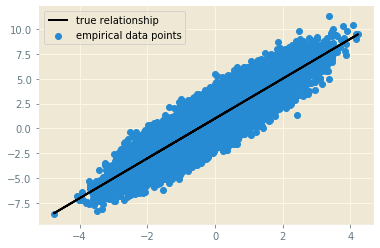

In [47]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.legend()
plt.show()

In [0]:
pdf = pd.DataFrame([x, y, y_noisy]).T

In [0]:
pdf.columns = ['x', 'y', 'y_noisy'] 

In [50]:
pdf.head(3)

,x,y,y_noisy
0,-2.024732,-3.049465,-2.983833
1,0.362263,1.724525,0.655740
2,-0.802380,-0.604759,-0.141469


In [51]:
pdf.shape

(100000, 3)

#### **Scikit-Learn Implementation**

In [65]:
import sklearn; 
print('Scikit-Learn Version:', sklearn.__version__)
from sklearn.linear_model import LinearRegression

Scikit-Learn Version: 0.22.1


In [0]:
intercept = np.full_like(x, 1)

In [72]:
intercept

array([1., 1., 1., ..., 1., 1., 1.])

In [0]:
x_intercept = np.vstack((intercept, x))

In [94]:
x_intercept

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [-2.02473247,  0.36226257, -0.80237953, ...,  1.04501005,
        -0.67421563,  0.49042816]])

In [95]:
x_intercept.shape

(2, 100000)

In [0]:
x_intercept = x_intercept.transpose()

In [99]:
x_intercept

array([[ 1.        , -2.02473247],
       [ 1.        ,  0.36226257],
       [ 1.        , -0.80237953],
       ...,
       [ 1.        ,  1.04501005],
       [ 1.        , -0.67421563],
       [ 1.        ,  0.49042816]])

In [100]:
x_intercept.shape

(100000, 2)

In [131]:
%%time
# instantiate and fit model
linear_regression_cpu = LinearRegression()
linear_regression_cpu.fit(x_intercept, y)

CPU times: user 7.02 ms, sys: 3.11 ms, total: 10.1 ms
Wall time: 12.4 ms


create new data and perform inference

In [0]:
test_arr = np.linspace(start=-5, stop=5, num=1000_000)

In [0]:
test_intercept = np.full_like(test_arr, 1)

In [0]:
test_arr_intercept = np.vstack((test_intercept, test_arr))

In [0]:
test_arr_intercept = test_arr_intercept.transpose()

In [109]:
test_arr_intercept

array([[ 1.     , -5.     ],
       [ 1.     , -4.99999],
       [ 1.     , -4.99998],
       ...,
       [ 1.     ,  4.99998],
       [ 1.     ,  4.99999],
       [ 1.     ,  5.     ]])

In [156]:
%%time
test_outputs_cpu = linear_regression_cpu.predict(test_arr_intercept)

CPU times: user 8.99 ms, sys: 8.91 ms, total: 17.9 ms
Wall time: 20.3 ms


In [158]:
test_outputs_cpu

array([-9.     , -8.99998, -8.99996, ..., 10.99996, 10.99998, 11.     ])

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


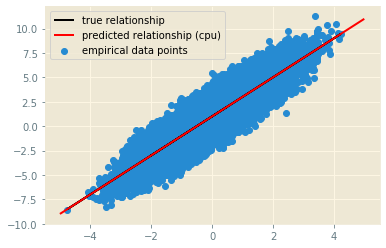

In [115]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(test_arr, test_outputs, color='red', label='predicted relationship (cpu)')
plt.legend()
plt.show()

#### **cuML Implementation**

The mathematical operations underlying many machine learning algorithms are often matrix multiplications. These types of operations are highly parallelizable and can be greatly accelerated using a GPU. cuML makes it easy to build machine learning models in an accelerated fashion while still using an interface nearly identical to Scikit-Learn. The below shows how to accomplish the same Linear Regression model but on a GPU.

using cuDF representation to implement

In [0]:
# cdf = cudf.DataFrame([intercept, x, y_noisy], columns=['CONSTANT', 'X', 'y'])          # too long to implemeent, must be something not right

In [0]:
cdf = cudf.DataFrame({'CONSTANT': intercept, 'X': x, 'y': y_noisy})                      # leave CONSTANT for now & this implementation is right and fast

In [146]:
cdf.head(3)

,CONSTANT,X,y
0,1.0,-2.024732,-2.983833
1,1.0,0.362263,0.655740
2,1.0,-0.802380,-0.141469


In [0]:
X_train = cdf[['CONSTANT', 'X']]

In [150]:
X_train

,CONSTANT,X
0,1.0,-2.024732
1,1.0,0.362263
2,1.0,-0.802380
3,1.0,-0.571530
4,1.0,0.254529
...,...,...
99995,1.0,0.148669
99996,1.0,-0.067222
99997,1.0,1.045010
99998,1.0,-0.674216


In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
from cuml.linear_model import LinearRegression as LinearRegressionGPU

In [151]:
%%time
# instantiate and fit model
linear_regression_gpu = LinearRegressionGPU()
linear_regression_gpu.fit(X_train, cdf['y'])

CPU times: user 142 ms, sys: 6.83 ms, total: 149 ms
Wall time: 171 ms


All model fitting and predicting steps are GPU accelerated.

In [153]:
test_arr_intercept

array([[ 1.     , -5.     ],
       [ 1.     , -4.99999],
       [ 1.     , -4.99998],
       ...,
       [ 1.     ,  4.99998],
       [ 1.     ,  4.99999],
       [ 1.     ,  5.     ]])

In [0]:
test_arr_intercept_cdf = cudf.DataFrame({'CONSTANT': test_intercept, 'X_test': test_arr }) 

In [155]:
test_arr_intercept_cdf

,CONSTANT,X_test
0,1.0,-5.00000
1,1.0,-4.99999
2,1.0,-4.99998
3,1.0,-4.99997
4,1.0,-4.99996
...,...,...
999995,1.0,4.99996
999996,1.0,4.99997
999997,1.0,4.99998
999998,1.0,4.99999


In [159]:
%%time
test_outputs_gpu = linear_regression_gpu.predict(test_arr_intercept_cdf)

CPU times: user 7.54 ms, sys: 961 µs, total: 8.5 ms
Wall time: 16 ms


In [160]:
test_outputs_gpu

0         -9.024248
1         -9.024228
2         -9.024208
3         -9.024188
4         -9.024168
            ...    
999995    11.015392
999996    11.015412
999997    11.015432
999998    11.015452
999999    11.015472
Length: 1000000, dtype: float64

using original numpy ndarray to implement and obviously the ndarray-ish implementation is faster

In [161]:
%%time
# instantiate and fit model
linear_regression_gpu = LinearRegressionGPU()
linear_regression_gpu.fit(x_intercept, y)

CPU times: user 11.3 ms, sys: 2.11 ms, total: 13.4 ms
Wall time: 18.4 ms


In [162]:
%%time
test_outputs_gpu_arr_input = linear_regression_gpu.predict(test_arr_intercept)

CPU times: user 8.73 ms, sys: 976 µs, total: 9.7 ms
Wall time: 11.8 ms


In [166]:
test_outputs_gpu

0         -9.024248
1         -9.024228
2         -9.024208
3         -9.024188
4         -9.024168
            ...    
999995    11.015392
999996    11.015412
999997    11.015432
999998    11.015452
999999    11.015472
Length: 1000000, dtype: float64

In [167]:
test_outputs_gpu_arr_input

0         -9.00000
1         -8.99998
2         -8.99996
3         -8.99994
4         -8.99992
            ...   
999995    10.99992
999996    10.99994
999997    10.99996
999998    10.99998
999999    11.00000
Length: 1000000, dtype: float64

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


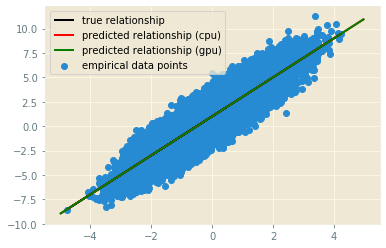

In [164]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(test_arr, test_outputs, color='red', label='predicted relationship (cpu)')
plt.plot(test_arr, test_outputs_gpu_arr_input.to_array(), color='green', label='predicted relationship (gpu)')
plt.legend()
plt.show()

####**A MORE REALISTIC EXAMPLE** 

In [169]:
from google.colab import files
uploaded = files.upload()

Saving mortgage.npy.gz to mortgage.npy.gz


In [0]:
import os
from cuml import LinearRegression as cuLinearRegression
from sklearn.linear_model import LinearRegression as skLinearRegression
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

# Select a particular GPU to run the notebook  
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [0]:
# check if the mortgage dataset is present and then extract the data from it, else just create a random dataset for regression 
import gzip
def load_data(nrows, ncols, cached = 'mortgage.npy.gz'):
    #split the dataset in a 80:20 split
    train_rows = int(nrows*0.8)
    if os.path.exists(cached):
        print('use mortgage data')

        with gzip.open(cached) as f:
            X = np.load(f)
        # the 4th column is 'adj_remaining_months_to_maturity'
        # used as the label
        X = X[:,[i for i in range(X.shape[1]) if i!=4]]
        y = X[:,4:5]
        rindices = np.random.randint(0,X.shape[0]-1,nrows)
        X = X[rindices,:ncols]
        y = y[rindices]
        df_y_train = pd.DataFrame({'fea%d'%i:y[0:train_rows,i] for i in range(y.shape[1])})
        df_y_test = pd.DataFrame({'fea%d'%i:y[train_rows:,i] for i in range(y.shape[1])})
    else:
        print('use random data')
        X,y = make_regression(n_samples=nrows,n_features=ncols,n_informative=ncols, random_state=0)
        df_y_train = pd.DataFrame({'fea0':y[0:train_rows,]})
        df_y_test = pd.DataFrame({'fea0':y[train_rows:,]})

    df_X_train = pd.DataFrame({'fea%d'%i:X[0:train_rows,i] for i in range(X.shape[1])})
    df_X_test = pd.DataFrame({'fea%d'%i:X[train_rows:,i] for i in range(X.shape[1])})

    return df_X_train, df_X_test, df_y_train, df_y_test

In [173]:
%%time
# nrows = number of samples
# ncols = number of features of each sample 

nrows = 2**20
ncols = 399

#split the dataset into training and testing sets, in the ratio of 80:20 respectively
X_train, X_test, y_train, y_test = load_data(nrows, ncols)
print('training data', X_train.shape)
print('training label', y_train.shape)
print('testing data', X_test.shape)
print('testing label', y_test.shape)
print('label', y_test.shape)

use mortgage data
training data (838860, 399)
training label (838860, 1)
testing data (209716, 399)
testing label (209716, 1)
label (209716, 1)
CPU times: user 19.9 s, sys: 4.67 s, total: 24.5 s
Wall time: 24.6 s


In [181]:
X_train

,fea0,fea1,fea2,fea3,fea4,fea5,fea6,fea7,fea8,fea9,fea10,fea11,fea12,fea13,fea14,fea15,fea16,fea17,fea18,fea19,fea20,fea21,fea22,fea23,fea24,fea25,fea26,fea27,fea28,fea29,fea30,fea31,fea32,fea33,fea34,fea35,fea36,fea37,fea38,fea39,...,fea359,fea360,fea361,fea362,fea363,fea364,fea365,fea366,fea367,fea368,fea369,fea370,fea371,fea372,fea373,fea374,fea375,fea376,fea377,fea378,fea379,fea380,fea381,fea382,fea383,fea384,fea385,fea386,fea387,fea388,fea389,fea390,fea391,fea392,fea393,fea394,fea395,fea396,fea397,fea398
0,0.597222,0.569429,0.256757,0.654297,0.398472,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.652778,0.098479,0.067568,0.501953,0.709690,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.472222,0.262802,0.076577,0.732422,0.268999,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.597222,0.540606,0.081081,0.730469,0.950141,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.708333,0.042452,0.135135,0.355469,0.782067,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838855,0.500000,0.263802,0.216216,0.671875,0.672698,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
838856,0.763889,0.048839,0.256757,0.185547,0.000000,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
838857,0.527778,0.305837,0.148649,0.349609,0.599517,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [182]:
y_train

,fea0
0,0.398472
1,0.709690
2,0.268999
3,0.950141
4,0.782067
...,...
838855,0.672698
838856,0.000000
838857,0.599517
838858,0.396864


In [183]:
X_test

,fea0,fea1,fea2,fea3,fea4,fea5,fea6,fea7,fea8,fea9,fea10,fea11,fea12,fea13,fea14,fea15,fea16,fea17,fea18,fea19,fea20,fea21,fea22,fea23,fea24,fea25,fea26,fea27,fea28,fea29,fea30,fea31,fea32,fea33,fea34,fea35,fea36,fea37,fea38,fea39,...,fea359,fea360,fea361,fea362,fea363,fea364,fea365,fea366,fea367,fea368,fea369,fea370,fea371,fea372,fea373,fea374,fea375,fea376,fea377,fea378,fea379,fea380,fea381,fea382,fea383,fea384,fea385,fea386,fea387,fea388,fea389,fea390,fea391,fea392,fea393,fea394,fea395,fea396,fea397,fea398
0,0.652778,0.096266,0.252252,0.304688,0.495778,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.694444,0.196900,0.022523,0.755859,0.494170,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.652778,0.232516,0.085586,0.728516,0.620426,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.694444,0.140192,0.117117,0.363281,0.341375,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.680556,0.196900,0.009009,0.761719,0.499799,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209711,0.638889,0.419287,0.054054,0.742188,0.396864,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209712,0.333333,0.164368,0.297297,0.636719,0.985525,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209713,0.527778,0.486566,0.130631,0.708984,0.341375,0.0,0.044486,0.059951,0.061698,0.716319,0.083032,0.231624,0.113612,0.212412,0.00678,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [184]:
y_test

,fea0
0,0.495778
1,0.494170
2,0.620426
3,0.341375
4,0.499799
...,...
209711,0.396864
209712,0.985525
209713,0.341375
209714,0.910736


In [174]:
%%time
# use the sklearn linear regression model to fit the training dataset 
skols = skLinearRegression(fit_intercept=True,
                           normalize=True)
skols.fit(X_train, y_train)

CPU times: user 44.6 s, sys: 2.64 s, total: 47.2 s
Wall time: 26.8 s


In [175]:
%%time
# calculate the mean squared error of the sklearn linear regression model on the testing dataset
sk_predict = skols.predict(X_test)
error_sk = mean_squared_error(y_test, sk_predict)

CPU times: user 188 ms, sys: 6.93 ms, total: 195 ms
Wall time: 159 ms


In [176]:
%%time
# convert the pandas dataframe to cudf format
X_cudf = cudf.DataFrame.from_pandas(X_train)
X_cudf_test = cudf.DataFrame.from_pandas(X_test)
y_cudf = y_train.values
y_cudf = y_cudf[:,0]
y_cudf = cudf.Series(y_cudf)

CPU times: user 1.25 s, sys: 121 ms, total: 1.37 s
Wall time: 1.39 s


In [177]:
%%time
# run the cuml linear regression model to fit the training dataset 
cuols = cuLinearRegression(fit_intercept=True,
                           normalize=True,
                           algorithm='eig')
cuols.fit(X_cudf, y_cudf)

CPU times: user 504 ms, sys: 89.2 ms, total: 593 ms
Wall time: 764 ms


In [178]:
%%time
# calculate the mean squared error of the testing dataset using the cuml linear regression model
cu_predict = cuols.predict(X_cudf_test).to_array()
error_cu = mean_squared_error(y_test, cu_predict)

CPU times: user 290 ms, sys: 6.98 ms, total: 297 ms
Wall time: 306 ms


In [180]:
# print the mean squared error of the sklearn and cuml model to compare the two
print("SKL MSE(y):", error_sk)
print("CUML MSE(y):", error_cu)

SKL MSE(y): 3.6389216e-13
CUML MSE(y): 2.841029e-10
